In [1]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization,Dropout,Input,LayerNormalization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import (BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives,
                                       TrueNegatives, Precision, Recall, AUC, binary_accuracy,Accuracy,
                                       TopKCategoricalAccuracy, CategoricalAccuracy,SparseCategoricalAccuracy)
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from datasets import load_dataset
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer,TFDebertaForSequenceClassification,DebertaTokenizerFast)

In [3]:
BATCH_SIZE=16

In [4]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d bitext/training-dataset-for-chatbotsvirtual-assistants
!unzip "/content/training-dataset-for-chatbotsvirtual-assistants.zip" -d "/content/dataset/"

  0% 0.00/1.16M [00:00<?, ?B/s]
100% 1.16M/1.16M [00:00<00:00, 86.5MB/s]
Archive:  /content/training-dataset-for-chatbotsvirtual-assistants.zip
  inflating: /content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.csv  
  inflating: /content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.xlsx  
  inflating: /content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/LICENSE.txt  
  inflating: /content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sampl

In [5]:
dataset=load_dataset("csv",
                       data_files="/content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['flags', 'utterance', 'category', 'intent'],
        num_rows: 21534
    })
})

In [7]:
dataset['train'][0]

{'flags': 'BILC',
 'utterance': "I don't have an online account, what do I have to do to register?",
 'category': 'ACCOUNT',
 'intent': 'create_account'}

In [8]:
intents=list(set(dataset['train']['intent']))
dict_intents={intents[i]: i for i in range(len(intents))}
print(dict_intents)
print(len(intents))

{'delivery_period': 0, 'contact_customer_service': 1, 'recover_password': 2, 'complaint': 3, 'contact_human_agent': 4, 'get_invoice': 5, 'payment_issue': 6, 'edit_account': 7, 'delivery_options': 8, 'check_cancellation_fee': 9, 'track_order': 10, 'get_refund': 11, 'check_payment_methods': 12, 'review': 13, 'create_account': 14, 'cancel_order': 15, 'delete_account': 16, 'set_up_shipping_address': 17, 'check_refund_policy': 18, 'place_order': 19, 'newsletter_subscription': 20, 'switch_account': 21, 'check_invoices': 22, 'change_shipping_address': 23, 'change_order': 24, 'track_refund': 25, 'registration_problems': 26}
27


In [9]:
def preprocess(dataset):
  return {'utterance':dataset['utterance'],
          'intent':dict_intents[dataset['intent']]}

In [10]:
prep_dataset=dataset.map(preprocess)

Map:   0%|          | 0/21534 [00:00<?, ? examples/s]

In [11]:
prep_dataset['train'][0]

{'flags': 'BILC',
 'utterance': "I don't have an online account, what do I have to do to register?",
 'category': 'ACCOUNT',
 'intent': 14}

In [12]:
model_id="microsoft/deberta-base"
tokenizer = DebertaTokenizerFast.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

In [13]:
def tokenizer_function(dataset):
  return tokenizer(dataset["utterance"],)

In [14]:
tokenized_dataset=prep_dataset.map(tokenizer_function)

Map:   0%|          | 0/21534 [00:00<?, ? examples/s]

In [15]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['flags', 'utterance', 'category', 'intent', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 21534
    })
})

In [16]:
tokenized_dataset['train'][0]

{'flags': 'BILC',
 'utterance': "I don't have an online account, what do I have to do to register?",
 'category': 'ACCOUNT',
 'intent': 14,
 'input_ids': [1,
  100,
  218,
  75,
  33,
  41,
  804,
  1316,
  6,
  99,
  109,
  38,
  33,
  7,
  109,
  7,
  5124,
  116,
  2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [18]:
tf_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids','attention_mask', 'intent'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

In [19]:
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'attention_mask':dataset['attention_mask'],},dataset['intent']

In [20]:
tf_dataset=tf_dataset.map(swap_positions)

In [21]:
train_dataset=tf_dataset.take(int(0.9*len(tf_dataset)))
val_dataset=tf_dataset.skip(int(0.9*len(tf_dataset)))

In [22]:
for i in val_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(16, 21), dtype=int64, numpy=
array([[    1,  7424,    47,  1394,    41,  2936,   147,     7,   146,
           10, 23523,  2267,  3674,    13,    10,   544,     6,  2540,
          116,     2,     0],
       [    1,   100,   437,  1372,    19,     5,   544,     8,    38,
          236,     7,   146,    10,  1129,     2,     0,     0,     0,
            0,     0,     0],
       [    1,   100,    33,    10,   936,   442,    10,  3207,     6,
           99,    64,    38,   109,     7,  6296,     9,    24,   116,
            2,     0,     0],
       [    1,   100,   236,     7,   304,   127,    97,  3018,  1316,
            6,    99,   109,    38,    33,     7,   109,     7,   464,
          106,   116,     2],
       [    1,  7424,    47,  1137,   162,     5,  1028,   346,     7,
         1511,  3653,   544,   116,     2,     0,     0,     0,     0,
            0,     0,     0],
       [    1,   100,   120,    41,  5849,  1579,    77,    38,  2120,
      

# Model

In [23]:
model=TFDebertaForSequenceClassification.from_pretrained(model_id,num_labels=len(intents))
model.summary()

tf_model.h5:   0%|          | 0.00/555M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaForSequenceClassification.

Some layers of TFDebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier', 'cls_dropout', 'pooler']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_deberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 deberta (TFDebertaMainLaye  multiple                  138601728 
 r)                                                              
                                                                 
 pooler (TFDebertaContextPo  multiple                  590592    
 oler)                                                           
                                                                 
 cls_dropout (TFDebertaStab  multiple                  0         
 leDropout)                                                      
                                                                 
 classifier (Dense)          multiple                  20763     
                                                                 
Total params: 139213083 (531.06 MB)
Trainable params: 139213083 (531.06 MB)
Non-trainable para

# Training

In [24]:
num_epochs = 2
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

In [25]:
optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)

In [26]:
model.compile(optimizer=optimizer,
    metrics=["accuracy"])

In [27]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2,)

Epoch 1/2


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


1211/1211 [==============================] - 353s 226ms/step - loss: 0.2772 - accuracy: 0.9373 - val_loss: 0.0075 - val_accuracy: 0.9995
Epoch 2/2
1211/1211 [==============================] - 259s 213ms/step - loss: 0.0077 - accuracy: 0.9991 - val_loss: 0.0025 - val_accuracy: 0.9995


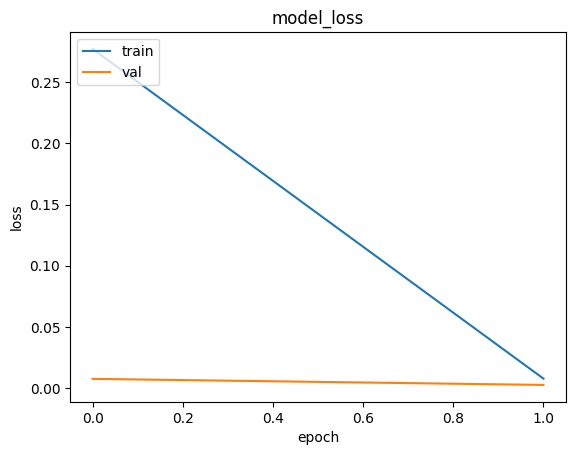

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

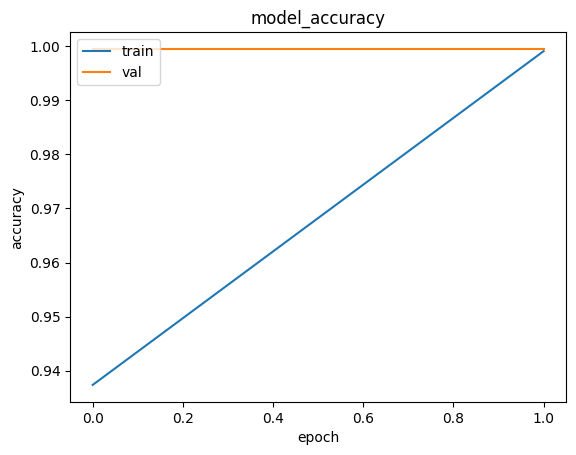

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluation

In [30]:
predicted = []
labels = []

for input, label in val_dataset:
  predicted.append(model(**input).logits)
  labels.append(label.numpy())

InvalidArgumentError: Exception encountered when calling layer 'embeddings' (type TFDebertaEmbeddings).

{{function_node __wrapped__Max_device_/job:localhost/replica:0/task:0/device:GPU:0}} Invalid reduction dimension (1 for input with 1 dimension(s) [Op:Max] name: 

Call arguments received by layer 'embeddings' (type TFDebertaEmbeddings):
  • input_ids=tf.Tensor(shape=(16, 27), dtype=int32)
  • position_ids=None
  • token_type_ids=tf.Tensor(shape=(16, 27), dtype=int32)
  • inputs_embeds=None
  • mask=tf.Tensor(shape=(16, 27), dtype=int32)
  • training=False

In [ ]:
print(predicted)
print(labels)

In [ ]:
print(tf.argmax(predicted[:-1],axis=-1).numpy())
print(labels[:-1])

In [ ]:
print(np.concatenate([np.array(labels[:-1]).flatten(),np.array(labels[-1]).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

In [ ]:
pred=np.concatenate([np.array(labels[:-1]).flatten(),np.array(labels[-1]).flatten()])
lab=np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])

In [ ]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(16,16))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
inputs = tokenizer(["Please how do i go about the account creation? ",
                    "After setting up my account, i feel like i need to change it. How do i go about that?",
                    "how do i know how much i need to pay?",
                    "purchased a product, which i now want to change"
                    ], padding=True,return_tensors="tf")

logits = model(**inputs).logits
outputs=tf.argmax(logits,axis=-1).numpy()

In [ ]:
print(outputs)

In [ ]:
reverse_dict_intents={i:intents[i] for i in range(len(intents))}
print(reverse_dict_intents)

In [ ]:
for i in outputs:
  print(reverse_dict_intents[i])